In [1]:
import numpy as np

from skimage import io
from skimage.util import img_as_float
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
%matplotlib inline

# Splitting Image Into Superpixels

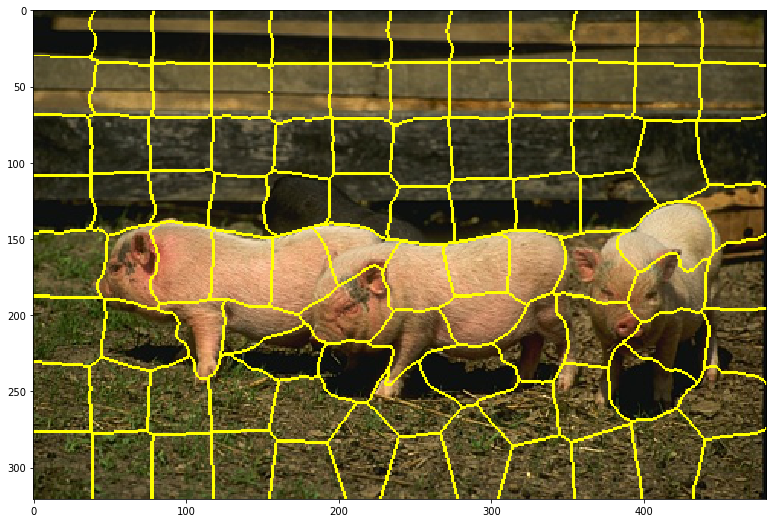

In [2]:
image = io.imread('./data/66053.jpg')
image = img_as_float(image)

segments = slic(image, n_segments=100, compactness=40, max_iter=10, sigma=3, convert2lab=True)

fig = plt.figure(figsize = (16, 9))
plt.imshow(mark_boundaries(image, segments))
plt.axis("on")
plt.show()

# Prior Label Information Setting Up

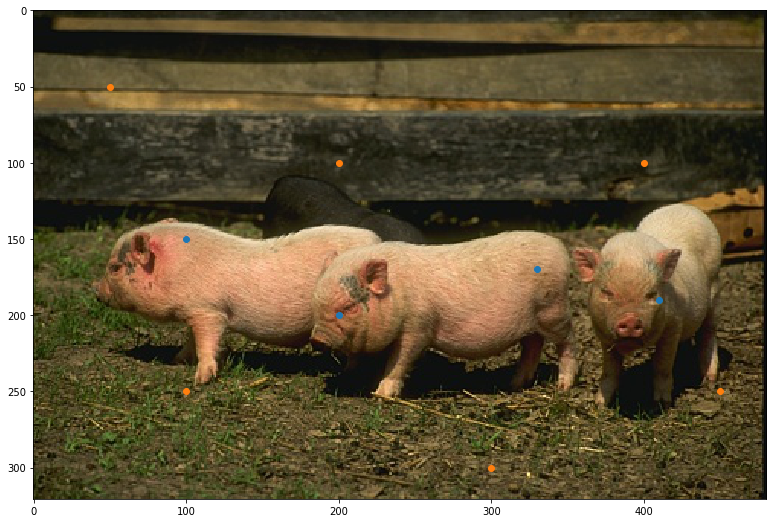

In [3]:
# foreground_pixels = np.array([[80, 380], [150, 400], [200, 320], [300, 380]])
# background_pixels = np.array([[50, 50], [150, 150], [270, 150], [200, 450], [50, 450], [50, 300]]) #49024
foreground_pixels = np.array([[150, 100], [200, 200], [170, 330], [190, 410]])
background_pixels = np.array([[50, 50], [100, 200], [250, 100], [300, 300], [250, 450], [100, 400]]) #66053

fig = plt.figure(figsize = (16, 9))
plt.imshow(image)
plt.scatter(foreground_pixels[:, 1], foreground_pixels[:, 0])
plt.scatter(background_pixels[:, 1], background_pixels[:, 0])
plt.axis("on")
plt.show()

### Prior label constraints

In [4]:
from utils import prior_label_constraints
l, u = prior_label_constraints(segments, foreground_pixels, background_pixels)

# Laplacian Matrix For Graph Based On Image Superpixels

In [5]:
from utils import Laplacian
L = Laplacian(image, segments, 'unnormalized')

# Results Visualization

In [6]:
from utils import get_binary_mask, mask_overlay

## SDP Relaxation

In [7]:
from sdp import SDP_relaxation
x_opt, _ = SDP_relaxation(L, l, u, options={'maxiter': 20, 'disp': True})

Function value: 4941.047384894314
Iterations number: 19


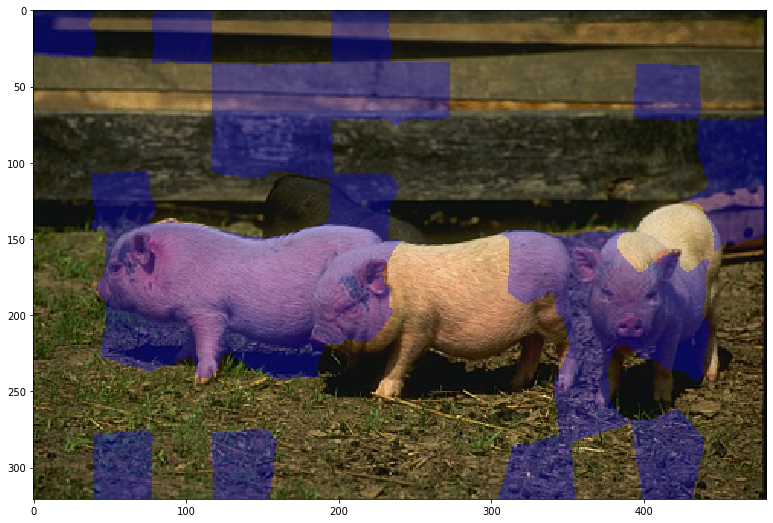

In [8]:
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));

## MPEC_EPM

In [9]:
from mpec import MPEC_EPM
x_opt, _ = MPEC_EPM(L, l, u, options={'maxiter': 20, 'disp': True})

Function value: 919.735528550081
Iterations number: 20


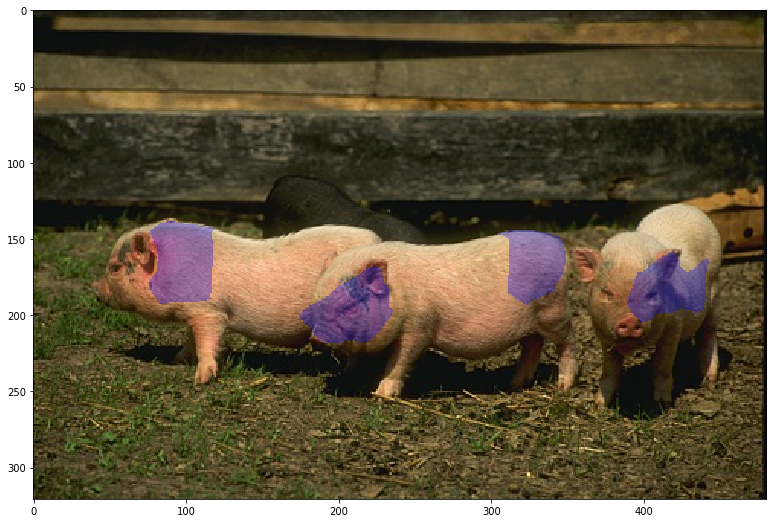

In [10]:
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));

In [11]:
def break_point_search(d=None, a=None, s=None):
    n = len(d)

    y = np.sort(np.hstack((-a.flatten() - d.flatten()*np.ones((n,)), -a.flatten())))
    l = 1
    r = 2*n
    L = n
    R = 0
    while 1:
        if (r - l == 1):
            S = (s - L) / (R - L)
            rho = y[l-1] + (y[r-1] - y[l-1]) * S
            break
        else:
            m = int(0.5 * (l + r))
            t = (-a.flatten() - y[m-1]*np.ones((n,)))/d.flatten()
            C = np.sum(np.array([max(0, min(t_i, 1)) for t_i in t]))
            if (C == s):
                rho = y[m-1]
                break
            elif (C > s):
                l = m
                L = C
            else:
                r = m
                R = C
    t = (-a.flatten() - rho)/d.flatten()
    x = np.array([max(0, min(t_i, 1)) for t_i in t])
    
    return x

def proj(a, k):
    x = np.zeros((len(a), 1))
    x[np.argsort(abs(a))[::-1][:k]] = 1
    
    return x

def dsf_mpec_epm(L, k, rho=0.01, sigma=np.sqrt(10), T=10, options={'maxiter': 100}):
    n = L.shape[0]
    M = np.max(np.linalg.eigvals(L))
    
    x = np.zeros((n,))
    v = np.zeros((n,))
    
    x_best = x
    f_min = np.inf
    for t in range(1, options['maxiter'] + 1):
        for i in range(50):
            grad = np.dot(L, x) - rho*2*(2*v - 1)
            xt = x
            x = break_point_search(np.ones((n, 1)), -(x - grad/M), k)
            if (i > 5) and (np.linalg.norm(x - xt)/np.linalg.norm(x) < 1e-5):
                break
                
        v = (np.sqrt(n)*(2*x - 1)/np.linalg.norm(2*x - 1) + 1)/2

        f_cur = np.dot(np.dot(x.reshape(1, -1), L), x.reshape(-1, 1))[0][0]
        if f_cur < f_min:
            f_min = f_cur
            x_best = x

        if t % T == 0:
            rho *= sigma
        
        error = n - np.dot((2*x - 1).reshape(1, -1), (2*v - 1).reshape(-1, 1))
        if (t > 10 and error < 1e-2):
            break

    x = proj(x_best, k)
    f = np.dot(np.dot(x.reshape(1, -1), L), x.reshape(-1, 1))[0][0]
    
    return x, f

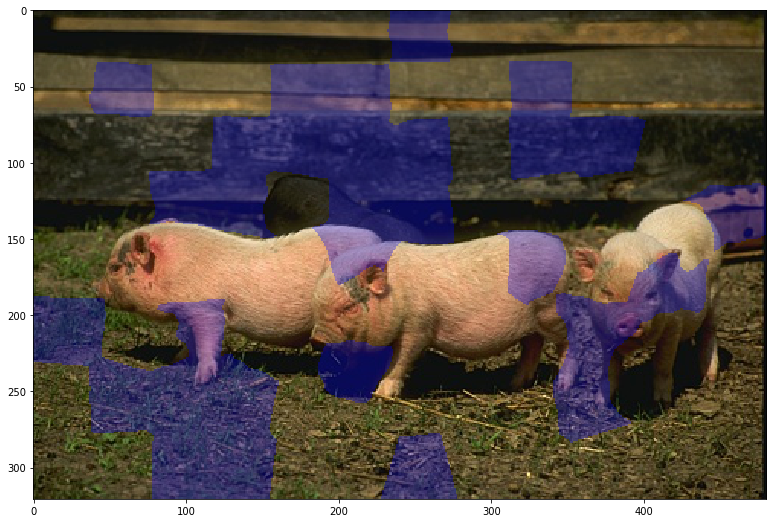

In [12]:
x_opt, _ = dsf_mpec_epm(L, k=30)
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));